# Regression Models

## Import Relevant Libraries

In [1]:
# Basic
import random
import numpy as np
import pandas as pd

# Data Operations
import category_encoders as ce
from sklearn.model_selection import train_test_split

# Data Visualisation
import matplotlib.pyplot as plt

# Hyperparameter Optimisation
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from itertools import product

# Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Sequential

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Model Evaluation
from sklearn.metrics import r2_score, mean_squared_error

## Global Params

In [15]:
SEED = 1212
DEVICE = "/GPU:0"
CORES = 4

## Import Data

In [16]:
# Import Data
df = pd.read_csv("data/sanitized_basic.csv")
df = df[['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP', 'INVESTIGATION_DURATION']]
df

,DIVISION_CODE,COUNCIL_AREA_CODE,GROUP,INVESTIGATION_DURATION
0,1,Aberdeen City,1.0,0
1,1,Aberdeen City,1.0,0
2,1,Aberdeen City,1.0,1
3,1,Aberdeenshire,3.0,0
4,1,Aberdeen City,3.0,0
...,...,...,...,...
2798123,3,Highland,7.0,1
2798124,3,Highland,7.0,1
2798125,3,Highland,7.0,0
2798126,3,Highland,7.0,0


## Data Preparation

In [17]:
# Split Target and Features
x = df.drop("INVESTIGATION_DURATION", axis=1)
y = df["INVESTIGATION_DURATION"]

In [18]:
# Encode Categorical Variables
encoder = ce.BinaryEncoder(cols=['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP'])
x = encoder.fit_transform(x)

In [19]:
# Train Test Split - ANN
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=SEED)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=0.20, shuffle=True, random_state=SEED)

In [25]:
# Train Test Split - DT
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=SEED)

## Helper Functions (For Visualisation)

In [21]:
def fit_scatter(y_true, y_pred):
    """Produces Fit Scatter Graph.
    Plots Measured Value Against Predicted Value.
    Only Shows Every 10th Point"""
    y_pred = y_pred.reshape(y_true.shape)
    plt.scatter(y_true[::10], y_pred[::10])
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')

In [22]:
def plot_learning(model_history):
    """Plots learning curve of Keras Model from History"""
    history_dict = model_history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    plt.plot(loss_values, 'b', label='Training')
    plt.plot(val_loss_values, 'r', label='Validation')
    plt.legend(loc="upper right")
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

## Model Optimisation

### Artificial Neural Network

In [10]:
def build_model(input_shape, n_layers, n_nodes, lr):
    """Takes input shape, layer dimensions and learning rate.
        Returns compiled model."""

    # Create Model
    mod = Sequential()

    # Input Layer
    mod.add(Input(shape=input_shape))

    # Hidden Layers
    for layer in range(n_layers):
        mod.add(Dense(n_nodes, activation='relu'))

    # Output Layer
    mod.add(Dense(1, activation='linear'))

    # Loss Function
    loss_func = keras.losses.MeanSquaredError()

    # Compile Model
    mod.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_func)

    return mod

In [11]:
def train_model(mod, feat, targ, val_feat, val_targ, batch):
    """Takes a model, training data, validation data and batch size.
        Returns Fitted Model
    """

    with tf.device(DEVICE):

        # Early Stopping Callback
        early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1, verbose=0, restore_best_weights=True)

        # Train Model
        hist = mod.fit(feat, targ,
                       epochs=100,
                       batch_size=batch,
                       callbacks=early,
                       validation_data=(val_feat, val_targ),
                       shuffle=True)

        # Return Model and Learning Curve
        return mod, hist

In [60]:
# Parameter Ranges
hidden_layers = list(np.arange(2, 7, 1))
nodes = list(np.arange(10, 128, 2))
learning_rate = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size = (128, 256, 512, 1024)

In [61]:
# All Combinations of Parameters
combs = list(product(hidden_layers, nodes, learning_rate, batch_size))

In [62]:
# Random Sample from Combinations
random.seed(SEED)
sample = random.sample(combs, 10)
sample

[(4, 80, 0.0001, 256),
 (4, 68, 0.0001, 128),
 (5, 68, 0.001, 512),
 (3, 46, 0.0001, 512),
 (6, 62, 1e-05, 256),
 (6, 92, 0.01, 128),
 (3, 36, 0.01, 1024),
 (4, 110, 0.001, 1024),
 (5, 90, 1e-05, 1024),
 (4, 62, 0.01, 512)]

In [63]:
# Conduct Trials

# Set Best Validation Loss to High Number
best_validation = 1e20
best_config_ann = None

# Try Each Random Configuration
for comb in sample:

    # Print Model Configuration
    print("--- Training Model ---")
    print("Hidden Layers: ", comb[0], " Nodes Per Layer: ", comb[1], " Learning Rate: ", comb[2], " Batch Size: ", comb[3])

    # Show Model
    model = build_model(x_train1.shape[1], comb[0], comb[1], comb[2])
    model, history = train_model(model, x_train1, y_train1, x_val1, y_val1, comb[3])

    # Get Validation Score
    val_score = model.evaluate(x_val1, y_val1)

    # Replace if Best
    if val_score < best_validation:
        best_validation = val_score
        best_config_ann = comb
    else:
        if best_config_ann is None:
            best_config_ann = comb

    print("Best Weights Validation Score: ", val_score)
    print("Best Validation Score: ", best_validation)
    print("Best Config: ", best_config_ann)

--- Training Model ---
Hidden Layers:  4  Nodes Per Layer:  80  Learning Rate:  0.0001  Batch Size:  256
Epoch 1/100
6559/6559 [==============================] - 14s 2ms/step - loss: 10078.2822 - val_loss: 10119.1289
Epoch 2/100
6559/6559 [==============================] - 14s 2ms/step - loss: 9965.7354 - val_loss: 10058.5059
Epoch 3/100
6559/6559 [==============================] - 31s 5ms/step - loss: 9937.0195 - val_loss: 10041.4463
Epoch 4/100
6559/6559 [==============================] - 14s 2ms/step - loss: 9930.2148 - val_loss: 10034.5352
Epoch 5/100
6559/6559 [==============================] - 14s 2ms/step - loss: 9927.5322 - val_loss: 10034.4287
Epoch 6/100
6559/6559 [==============================] - 14s 2ms/step - loss: 9926.8301 - val_loss: 10031.8896
Epoch 7/100
6559/6559 [==============================] - 14s 2ms/step - loss: 9925.5605 - val_loss: 10032.3037
Epoch 8/100
6559/6559 [==============================] - 14s 2ms/step - loss: 9924.9082 - val_loss: 10034.3623
Epoch 

In [64]:
# Get Best Parameters
best_config_ann

(5, 68, 0.001, 512)

### Decision Tree

In [27]:
dt_grid = {
    "criterion": ['squared_error', 'poisson'],
    "splitter": ['best', 'random'],
    "max_depth": [1, 10, 100, 1000, None],
    "min_samples_split": [2, 10, 20, 30, 40],
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features":['auto']
}

In [30]:
splitter = RepeatedKFold(n_splits=2, n_repeats=5, random_state=SEED)

dt = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=dt_grid,
                  cv=splitter,
                  n_jobs=CORES,
                  scoring='neg_mean_squared_error')

# Grid Search
dt.fit(x_train2, y_train2)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=2, random_state=1212),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'criterion': ['squared_error', 'poisson'],
                         'max_depth': [1, 10, 100, 1000, None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 10, 20, 30, 40],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [40]:
best_config_dt = dt.best_params_
best_config_dt

{'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'splitter': 'best'}


## Model Evaluation

### Artificial Neural Network

In [12]:
# Retrain Best Model
best_ann = build_model(x_train1.shape[1], 5, 68, 0.001)
best_ann, history = train_model(best_ann, x_train1, y_train1, x_val1, y_val1, 512)

Epoch 1/100
3280/3280 [==============================] - 10s 3ms/step - loss: 9977.8545 - val_loss: 10036.5078
Epoch 2/100
3280/3280 [==============================] - 9s 3ms/step - loss: 9935.0938 - val_loss: 10032.8350
Epoch 3/100
3280/3280 [==============================] - 10s 3ms/step - loss: 9932.2871 - val_loss: 10044.5186
Epoch 4/100
3280/3280 [==============================] - 10s 3ms/step - loss: 9928.5947 - val_loss: 10036.8535
Epoch 5/100
3280/3280 [==============================] - 10s 3ms/step - loss: 9928.5391 - val_loss: 10029.9385
Epoch 6/100
3280/3280 [==============================] - 10s 3ms/step - loss: 9927.6455 - val_loss: 10034.3184
Epoch 7/100
3280/3280 [==============================] - 10s 3ms/step - loss: 9928.0557 - val_loss: 10030.4307
Epoch 8/100
3280/3280 [==============================] - 10s 3ms/step - loss: 9925.9209 - val_loss: 10029.4102
Epoch 9/100
3280/3280 [==============================] - 10s 3ms/step - loss: 9926.4658 - val_loss: 10028.5010
Ep

In [13]:
# Get Training and Test Scores
ann_pred_train = best_ann.predict(x_train1)
ann_pred_test = best_ann.predict(x_test1)

print("Train R2 Score: ", r2_score(y_train1, ann_pred_train))
print("Test R2 Score: ", r2_score(y_test1, ann_pred_test))

print("Train MSE Score: ", mean_squared_error(y_train1, ann_pred_train))
print("Test MSE Score: ", mean_squared_error(y_test1, ann_pred_test))

Train R2 Score:  0.02811282057673148
Test R2 Score:  0.02829990445698405
Train MSE Score:  9918.767044502894
Test MSE Score:  9770.39028624214


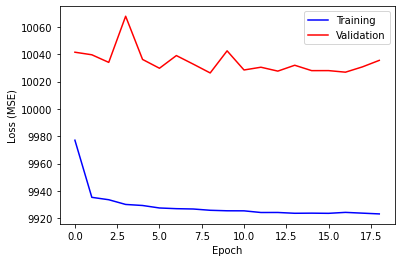

In [67]:
# Get Learning Curve
plot_learning(history)
plt.savefig('images/regression/reg_adam_learning.pdf')
plt.show()

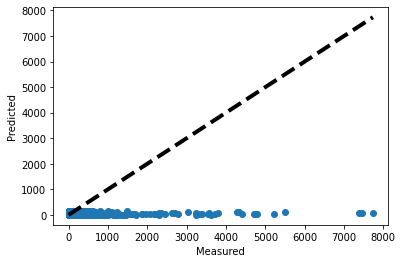

In [68]:
# Get Fit Scatter
fit_scatter(y_test1, ann_pred_test)
plt.savefig('images/regression/reg_adam_fit.pdf')
plt.show()

### Decision Tree

In [14]:
# Retrain Best Model
best_dt = DecisionTreeRegressor(criterion='squared_error',
                                max_depth=10,
                                max_features='auto',
                                min_samples_leaf=1,
                                min_samples_split=30,
                                splitter='best')

best_dt.fit(x_train2, y_train2)

DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_split=30)

In [15]:
# Get Training and Test Scores
dt_pred_train = best_dt.predict(x_train2)
dt_pred_test = best_dt.predict(x_test2)

print("Train R2 Score: ", r2_score(y_train2, dt_pred_train))
print("Test R2 Score: ", r2_score(y_test2, dt_pred_test))

print("Train MSE Score: ", mean_squared_error(y_train2, dt_pred_train))
print("Test MSE Score: ", mean_squared_error(y_test2, dt_pred_test))

Train R2 Score:  0.028668076025615274
Test R2 Score:  0.028942924057086206
Train MSE Score:  9935.67081463537
Test MSE Score:  9763.924760012886


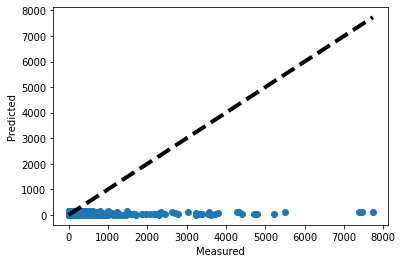

In [37]:
# Get Fit Scatter
fit_scatter(y_test2, dt_pred_test)
plt.savefig('images/reg_dt_fit.pdf')
plt.show()